In [1]:
import numpy as np
import phoebe
import matplotlib.pyplot as plt
%matplotlib inline

/Users/khambl02/.venvs/phoebe/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
b = phoebe.load('bundles/lum_adjusted.bundle')

Previously, we had used heavily detrended data. Now we want to use lighly detrended data (data that have been shifted virtically and median normalized)and use GPs to fit the trends. Here we update the data. As PHOEBE will only fit in time space for GPs, we need to select a section of data where we will create a model and fit the GPs. The results can be extrapolated later during "compute" to ensure the fit is correct.

In [4]:
lc = np.loadtxt('data/detrended_gps.dat')

b['times@lc01@dataset'] = lc[:,0]
b['fluxes@lc01@dataset'] = lc[:,1]
b['sigmas@lc01@dataset'] = lc[:,2]

When using GPs, we must compute everything in time space. The times must also be spread over the complete data set. To do this we must flip the constraint to fit in time space and then update the times so that they span the complete data set.

In [6]:
b['compute_phases@lc01']=phoebe.linspace(-0.5,0.5,1001)

In [7]:
print((b.get_value('compute_phases@lc01@dataset')))

[-0.12985617 -0.12748751 -0.12511886 ...  0.41838748  0.42075613
  0.42312479]


We now compute a model with and without GPs so that we can compare them.

In [8]:
b.run_compute(model='model_without_gps', overwrite=True,compute='comp_phys')

100%|███████████████████████████████████████| 1501/1501 [02:01<00:00, 12.37it/s]


<ParameterSet: 3 parameters | qualifiers: times, fluxes, comments>

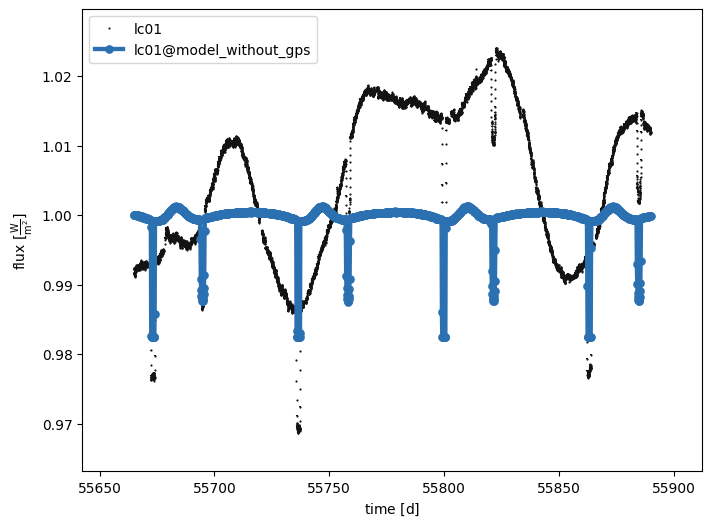

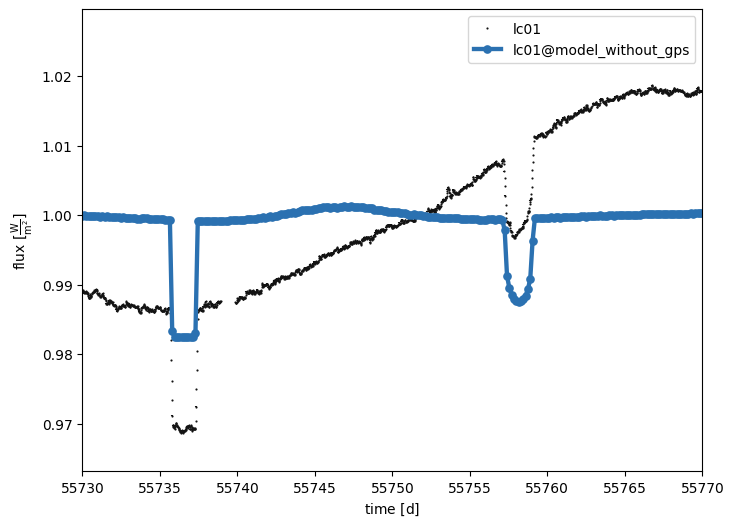

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [9]:
b.plot(['dataset', 'model'],model='model_without_gps',s={'dataset': 0.005, 'model': 0.02}, 
           marker={'dataset': '.','model':'.'},legend=True,show=True)
b.plot(['dataset', 'model'],model='model_without_gps',s={'dataset': 0.005, 'model': 0.02}, 
           marker={'dataset': '.','model':'.'},legend=True,xlim = (55730, 55770),show=True)

Provide parameters for the gaussian processes. The rho parameter is spot modulation timescale. Tau is the damping time scale, Q is the SHO quality factor and sigma is the characteristic amplitude. See https://www.aanda.org/articles/aa/full_html/2022/12/aa43545-22/aa43545-22.html for further reading.

In [22]:
f = 0.027466# dominant frequency of the spot (this spot changes over time)
f_spot = 0.5*f# The spot period is twice the dominant peirod or half the dominant frequency
w_spot = 2*np.pi*f_spot #The angular frequency of the spot

Q = 5. #gp input, Q is the damping fator where Q >> 1 for pulsations and oscillations
s_spot = 0.0000001

rho1 = 1./f_spot #gp paramter rho is the period of the spot
print("rho = ", rho1)

tau1 = (2*Q)/(w_spot) #gp paramter tau is the damping timescale 
print("tau = ", tau1)

sigma1 = np.sqrt(s_spot*w_spot*Q) #sigma is the standard deviation of the process
print("sigma = ", sigma1)

rho =  72.81730139081046
tau =  115.8923345895983
sigma =  0.00020771011509252172


Add the Gaussian process feature:

In [23]:
b.add_gaussian_process(kind='celerite2', kernel='sho', sigma=sigma1, rho=rho1, tau=tau1, dataset="lc01",label='gp_celerite201',overwrite=True)


<ParameterSet: 14 parameters | contexts: feature, compute>

Set the Gaussian process to product because we are modeling the spots, which are an intrinsic feature (sum for noise).

In [24]:
b.set_value('alg_operation', 'product')

In [1]:
print(b['gp_celerite2'])

NameError: name 'b' is not defined

Now we tell the GPs not to fit the eclipse regions. We do this by excluding the phases that LCgeometry identified as the eclipse regions (masked phases). If the masked phases did not line up well, or if your ephemeris has changed since lcgeometry (i.e. the period or t0 have been updated, or if per0 has changed significantly), then you may need to set this manually (or run LC geometry again two times). 

In [26]:
b.set_value_all('gp_exclude_phases@comp_phys@lc01',b['value@fitted_values@lcgeom'][-1])#[[-0.03,0.03], [0.315,0.37]])

In [27]:
print(b['value@gp_exclude_phases@comp_phys@lc01'])

[[-0.04301712  0.04225664]
 [ 0.30523073  0.37845957]]


In [28]:
print(b['gp_exclude_phases_enabled@comp_phys@lc01'])

Parameter: gp_exclude_phases_enabled@lc01@comp_phys@compute
                       Qualifier: gp_exclude_phases_enabled
                     Description: Whether to apply the mask in gp_exclude_phases during gaussian process fitting.
                           Value: True
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: ds_has_enabled_feature:gp_*



In [29]:
b.run_compute(model='model_with_gps', overwrite=True,compute='comp_phys')

100%|███████████████████████████████████████| 1501/1501 [01:47<00:00, 14.01it/s]


<ParameterSet: 5 parameters | qualifiers: fluxes, gps, fluxes_nogps, comments, times>

Plot the GPs with your model:

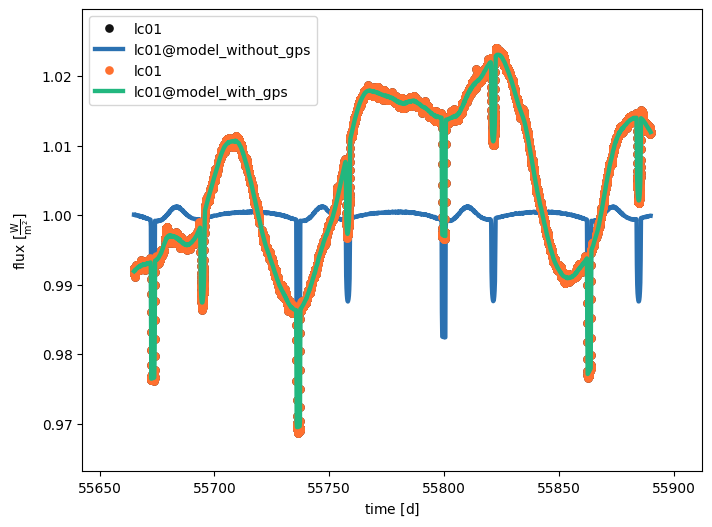

In [35]:
_ = b.plot(dataset='lc01',model='model_without_gps',
           marker={'dataset': '.'},ls='solid',legend=True,
           show=False)
__ = b.plot(dataset='lc01',model='model_with_gps',
           marker={'dataset': '.'},ls='solid',legend=True,
           show=True)#ylim = (0.975,1.005),

Plot the residuals:

/usr/local/lib/python3.10/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


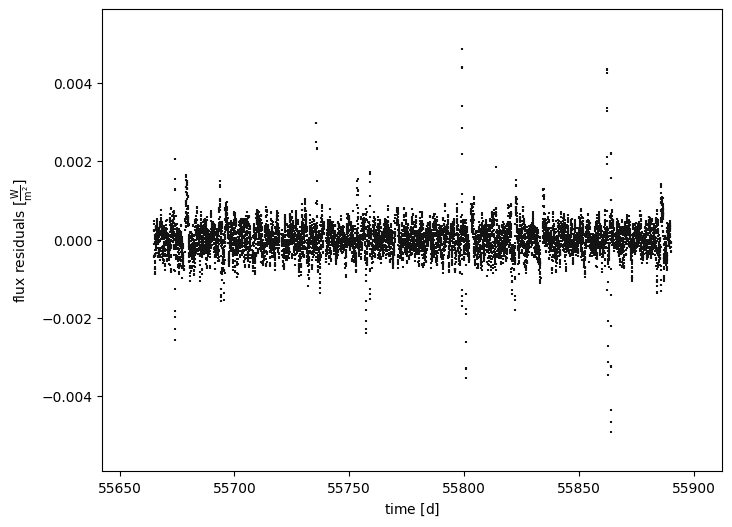

In [31]:
__ = b.plot(dataset='lc01',model='model_with_gps',y='residuals',
           marker={'dataset': '.'},ls='solid',
           show=True)

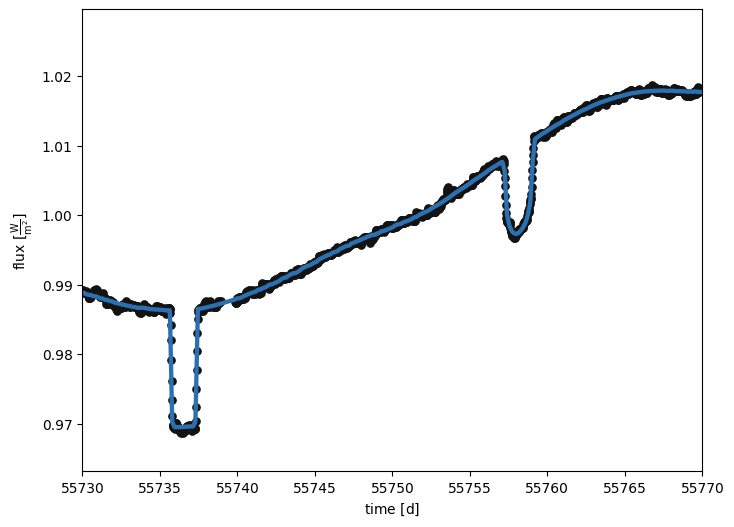

In [32]:
_ = b.plot(dataset='lc01', xlim = (55730, 55770),
           model='model_with_gps',
           marker={'dataset': '.'},ls='solid',
           show=True)

In [38]:
print(b['value@gps@model_with_gps'])

[-0.00812633 -0.00811906 -0.00811176 ...  0.01205393  0.01204022
  0.01202648]


Plot the GP part of the model and the fluxes seperately:

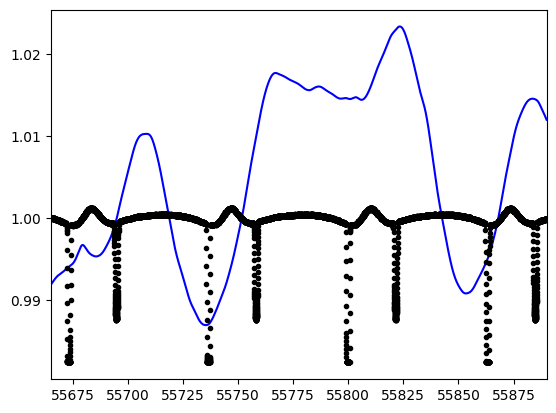

In [40]:
gps = b['value@gps@model_with_gps']
no_gps = b['value@fluxes_nogps@model_with_gps']
gp_times = b['value@times@model_with_gps']

plt.plot(gp_times,gps+1.,'b-')
plt.plot(gp_times,no_gps,'k.')

plt.xlim(gp_times[0], gp_times[3000])
#plt.ylim(0.96, 1.02)
plt.show()

Let's plot the GPs in phase to make sure there are no obvious bumps at the eclipse phases:

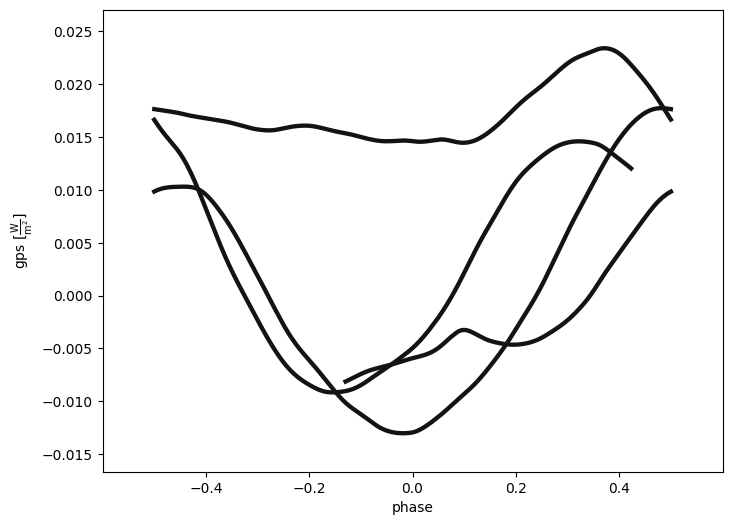

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [43]:
b.plot(dataset='lc01',model='model_with_gps',y='gps',x='phase',show=True)

In [44]:
b.save('./bundles/after_gps.bundle')

'./bundles/after_gps.bundle'